# Divvy Trips Data - Exploratory Data Analysis

**Objective:** Comprehensive analysis of Divvy bike-share trip data from S3 Bronze layer to understand:
- Trip patterns and distributions
- Rider behavior differences (casual vs member)
- Temporal usage patterns
- Station popularity and geographic distribution
- Data quality assessment

**Data Source:** S3 Bronze Layer - `s3://divvybikes-dev-bronze-96wb3c9c/divvy-data/`

**Analysis Period:** 2023-2024 Historical Trip Data. But for EDA, we'll only take sample dataset for Q1 2023 and Q1 2024.

**Technical Note:** This notebook uses **Python-only** for reliable, kernel-safe analysis. R integration removed due to memory issues.

In [1]:
# Setup Python Environment (Pure Python - No R)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import boto3
from io import StringIO
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("✅ Python environment setup complete!")
print("🐍 Pure Python approach - no R dependencies")
print("📊 Ready for kernel-safe EDA analysis")

# Test basic functionality
print(f"\n🧪 Environment test:")
print(f"✅ pandas version: {pd.__version__}")
print(f"✅ numpy version: {np.__version__}")
print(f"✅ matplotlib available")
print(f"✅ seaborn available")
print(f"✅ boto3 available for S3 access")

✅ Python environment setup complete!
🐍 Pure Python approach - no R dependencies
📊 Ready for kernel-safe EDA analysis

🧪 Environment test:
✅ pandas version: 2.3.1
✅ numpy version: 2.3.1
✅ matplotlib available
✅ seaborn available
✅ boto3 available for S3 access


In [2]:
# Configure AWS S3 Connection (Pure Python)
import boto3
from botocore.exceptions import ClientError

print("🔧 Setting up AWS S3 connection (Python-only)...")

# AWS S3 Configuration
AWS_REGION = 'ap-southeast-2'
BUCKET_NAME = 'divvybikes-dev-bronze-96wb3c9c'
S3_PREFIX = 'divvy-trips/'

def test_s3_connection():
    """Test S3 connection and list sample files"""
    try:
        # Initialize S3 client
        s3_client = boto3.client('s3', region_name=AWS_REGION)
        
        print(f"📡 Testing S3 connection to bucket: {BUCKET_NAME}")
        print(f"🌏 Region: {AWS_REGION}")
        print(f"📁 Prefix: {S3_PREFIX}")
        
        # List objects with prefix
        response = s3_client.list_objects_v2(
            Bucket=BUCKET_NAME,
            Prefix=S3_PREFIX,
            MaxKeys=10
        )
        
        if 'Contents' in response:
            files = [obj['Key'] for obj in response['Contents']]
            print(f"✅ S3 connection successful!")
            print(f"📄 Found {len(files)} files")
            print("📋 Sample files:")
            for file in files[:5]:
                print(f"   • {file}")
            return True
        else:
            print("⚠️ No files found in bucket")
            return False
            
    except ClientError as e:
        print(f"❌ S3 connection failed: {e}")
        return False
    except Exception as e:
        print(f"❌ Unexpected error: {e}")
        return False

# Test the connection
s3_connected = test_s3_connection()

if s3_connected:
    print("\n🎉 AWS S3 setup complete - ready for data loading!")
else:
    print("\n📝 S3 connection failed. Check:")
    print("   1. AWS credentials are configured")
    print("   2. Bucket exists and is accessible")
    print("   3. Region setting is correct")

🔧 Setting up AWS S3 connection (Python-only)...
📡 Testing S3 connection to bucket: divvybikes-dev-bronze-96wb3c9c
🌏 Region: ap-southeast-2
📁 Prefix: divvy-trips/
✅ S3 connection successful!
📄 Found 10 files
📋 Sample files:
   • divvy-trips/year=2023/month=01/202301-divvy-tripdata.csv
   • divvy-trips/year=2023/month=02/202302-divvy-tripdata.csv
   • divvy-trips/year=2023/month=03/202303-divvy-tripdata.csv
   • divvy-trips/year=2023/month=04/202304-divvy-tripdata.csv
   • divvy-trips/year=2023/month=05/202305-divvy-tripdata.csv

🎉 AWS S3 setup complete - ready for data loading!


In [3]:
# Data Loading Function (Pure Python - Kernel Safe)
# Load Q1 2023 & Q1 2024 Divvy trip data from S3

def load_divvy_data_q1(years=["2023", "2024"], max_files=2, sample_frac=0.2, max_rows_per_file=8000):
    """
    Load Divvy bike trip data for Q1 of specified years (Python-only, kernel-safe)
    
    Args:
        years: List of years to include
        max_files: Maximum number of files to process
        sample_frac: Fraction of data to sample from each file
        max_rows_per_file: Maximum rows to read per file
    
    Returns:
        pandas DataFrame with combined Q1 data
    """
    try:
        print("🚴 Loading Divvy Q1 data (Python-only, kernel-safe)")
        print("=" * 60)
        print(f"🎯 Target: Q1 {', '.join(years)}")
        print(f"📁 Max files: {max_files}")
        print(f"🎲 Sample fraction: {sample_frac}")
        print(f"📊 Max rows per file: {max_rows_per_file}")
        
        # Initialize S3 client
        s3_client = boto3.client('s3', region_name=AWS_REGION)
        
        # Create Q1 month patterns (Jan, Feb, Mar)
        q1_patterns = []
        for year in years:
            for month in ["01", "02", "03"]:
                q1_patterns.append(f"{year}{month}")
        
        print(f"🔍 Looking for patterns: {q1_patterns}")
        
        # List all objects in bucket
        response = s3_client.list_objects_v2(
            Bucket=BUCKET_NAME,
            Prefix=S3_PREFIX,
            MaxKeys=100
        )
        
        if 'Contents' not in response:
            print("❌ No files found in S3 bucket")
            return None
        
        # Filter for matching CSV files
        matching_files = []
        for obj in response['Contents']:
            key = obj['Key']
            if key.endswith('.csv'):
                # Check if any Q1 pattern matches
                for pattern in q1_patterns:
                    if pattern in key:
                        matching_files.append(key)
                        break
        
        if not matching_files:
            print(f"❌ No Q1 files found for years {years}")
            return None
        
        # Limit files to prevent memory issues
        matching_files = matching_files[:max_files]
        print(f"📄 Processing {len(matching_files)} files:")
        for file in matching_files:
            print(f"   • {file}")
        
        # Load and combine data
        dataframes = []
        total_records = 0
        
        for i, file_key in enumerate(matching_files, 1):
            print(f"\n📥 Loading file {i}/{len(matching_files)}: {file_key.split('/')[-1]}")
            
            try:
                # Download file content
                obj = s3_client.get_object(Bucket=BUCKET_NAME, Key=file_key)
                content = obj['Body'].read().decode('utf-8')
                
                # Read CSV with row limit
                df = pd.read_csv(StringIO(content), nrows=max_rows_per_file)
                print(f"   📊 Read {len(df)} rows")
                
                # Sample the data if needed
                if sample_frac < 1.0 and len(df) > 1000:
                    original_size = len(df)
                    df = df.sample(frac=sample_frac, random_state=42)
                    print(f"   🎲 Sampled to {len(df)} rows ({sample_frac:.1%})")
                
                # Add metadata
                df['source_file'] = file_key.split('/')[-1]
                df['load_timestamp'] = pd.Timestamp.now()
                
                dataframes.append(df)
                total_records += len(df)
                print(f"   ✅ Added {len(df)} records (total: {total_records})")
                
                # Memory safety check
                if total_records > 20000:
                    print("   ⚠️ Reached memory safety limit (20K records)")
                    break
                    
            except Exception as e:
                print(f"   ❌ Error loading {file_key}: {e}")
                continue
        
        if not dataframes:
            print("❌ No data loaded successfully")
            return None
        
        # Combine all DataFrames
        print(f"\n🔗 Combining {len(dataframes)} datasets...")
        combined_df = pd.concat(dataframes, ignore_index=True)
        
        # Summary
        print(f"\n🎉 Data loading complete!")
        print(f"📊 Total records: {len(combined_df):,}")
        print(f"📁 Files processed: {len(dataframes)}")
        print(f"💾 Memory usage: ~{combined_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
        
        # Show date range if available
        if 'started_at' in combined_df.columns:
            combined_df['started_at'] = pd.to_datetime(combined_df['started_at'])
            date_min = combined_df['started_at'].min()
            date_max = combined_df['started_at'].max()
            print(f"📅 Date range: {date_min.strftime('%Y-%m-%d')} to {date_max.strftime('%Y-%m-%d')}")
        
        return combined_df
        
    except Exception as e:
        print(f"❌ Critical error in data loading: {e}")
        return None

print("✅ Python data loading function ready!")
print("💡 Call: load_divvy_data_q1(years=['2023', '2024'])")

✅ Python data loading function ready!
💡 Call: load_divvy_data_q1(years=['2023', '2024'])


In [4]:
# Load Divvy Q1 Data (Test the Function)
# Test loading Q1 2023 & Q1 2024 data

print("🧪 Testing Divvy Q1 data loading...")

# Load the data with conservative settings
divvy_q1_data = load_divvy_data_q1(
    years=["2023", "2024"],
    max_files=2,
    sample_frac=0.3,  # 30% sample
    max_rows_per_file=6000
)

if divvy_q1_data is not None:
    print("\n📊 Data Loading Summary:")
    print("=" * 40)
    print(f"✅ Successfully loaded {len(divvy_q1_data):,} records")
    print(f"📋 Columns: {len(divvy_q1_data.columns)}")
    print(f"💾 Memory usage: ~{divvy_q1_data.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    
    # Show basic info
    print(f"\n🔍 Column names:")
    for i, col in enumerate(divvy_q1_data.columns):
        print(f"   {i+1:2d}. {col}")
    
    # Show data types
    print(f"\n📈 Data types summary:")
    dtype_counts = divvy_q1_data.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"   {dtype}: {count} columns")
    
    # Quick preview
    print(f"\n👀 First 3 rows:")
    print(divvy_q1_data.head(3))
    
    print(f"\n🎉 Data ready for EDA analysis!")
    
else:
    print("❌ Data loading failed")
    print("📝 Check S3 connection and bucket access")

🧪 Testing Divvy Q1 data loading...
🚴 Loading Divvy Q1 data (Python-only, kernel-safe)
🎯 Target: Q1 2023, 2024
📁 Max files: 2
🎲 Sample fraction: 0.3
📊 Max rows per file: 6000
🔍 Looking for patterns: ['202301', '202302', '202303', '202401', '202402', '202403']
📄 Processing 2 files:
   • divvy-trips/year=2023/month=01/202301-divvy-tripdata.csv
   • divvy-trips/year=2023/month=02/202302-divvy-tripdata.csv

📥 Loading file 1/2: 202301-divvy-tripdata.csv
   📊 Read 6000 rows
   🎲 Sampled to 1800 rows (30.0%)
   ✅ Added 1800 records (total: 1800)

📥 Loading file 2/2: 202302-divvy-tripdata.csv
   📊 Read 6000 rows
   🎲 Sampled to 1800 rows (30.0%)
   ✅ Added 1800 records (total: 3600)

🔗 Combining 2 datasets...

🎉 Data loading complete!
📊 Total records: 3,600
📁 Files processed: 2
💾 Memory usage: ~2.4 MB
📅 Date range: 2023-01-01 to 2023-02-28

📊 Data Loading Summary:
✅ Successfully loaded 3,600 records
📋 Columns: 15
💾 Memory usage: ~2.1 MB

🔍 Column names:
    1. ride_id
    2. rideable_type
    3

In [6]:
# Basic Data Exploration & Quality Assessment
# Analyze the Q1 2023 & Q1 2024 Divvy trips data

if 'divvy_q1_data' in locals() and divvy_q1_data is not None:
    print("📊 Basic Data Exploration")
    print("=" * 50)
    
    # Dataset overview
    print(f"📋 Dataset Overview:")
    print(f"   Records: {len(divvy_q1_data):,}")
    print(f"   Features: {len(divvy_q1_data.columns)}")
    print(f"   Memory: ~{divvy_q1_data.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    
    # Data types
    print(f"\n🔍 Data Types:")
    print(divvy_q1_data.dtypes)
    
    # Missing values analysis
    print(f"\n❓ Missing Values Analysis:")
    missing = divvy_q1_data.isnull().sum()
    missing_pct = (missing / len(divvy_q1_data)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing,
        'Missing %': missing_pct
    }).round(2)
    missing_df = missing_df[missing_df['Missing Count'] > 0]
    
    if len(missing_df) > 0:
        print(missing_df)
    else:
        print("✅ No missing values found!")
    
    # Key categorical variables
    print(f"\n👥 Rider Type Distribution:")
    if 'member_casual' in divvy_q1_data.columns:
        rider_counts = divvy_q1_data['member_casual'].value_counts()
        print(rider_counts)
        print(f"Percentage breakdown:")
        print((rider_counts / len(divvy_q1_data) * 100).round(1))
    
    print(f"\n🚲 Bike Type Distribution:")
    if 'rideable_type' in divvy_q1_data.columns:
        bike_counts = divvy_q1_data['rideable_type'].value_counts()
        print(bike_counts)
        print(f"Percentage breakdown:")
        print((bike_counts / len(divvy_q1_data) * 100).round(1))
    
    # Temporal analysis
    if 'started_at' in divvy_q1_data.columns:
        print(f"\n📅 Temporal Analysis:")
        
        # Convert to datetime if not already
        if not pd.api.types.is_datetime64_any_dtype(divvy_q1_data['started_at']):
            divvy_q1_data['started_at'] = pd.to_datetime(divvy_q1_data['started_at'])
        
        # Date range
        date_min = divvy_q1_data['started_at'].min()
        date_max = divvy_q1_data['started_at'].max()
        print(f"   Date range: {date_min.strftime('%Y-%m-%d')} to {date_max.strftime('%Y-%m-%d')}")
        
        # Add temporal features
        divvy_q1_data['year'] = divvy_q1_data['started_at'].dt.year
        divvy_q1_data['month'] = divvy_q1_data['started_at'].dt.month
        divvy_q1_data['month_name'] = divvy_q1_data['started_at'].dt.strftime('%B')
        divvy_q1_data['hour'] = divvy_q1_data['started_at'].dt.hour
        divvy_q1_data['day_of_week'] = divvy_q1_data['started_at'].dt.strftime('%A')
        
        # Monthly distribution
        print(f"\n📊 Monthly Distribution:")
        monthly_dist = divvy_q1_data.groupby(['year', 'month_name']).size().reset_index(name='trips')
        print(monthly_dist)
        
        # Hourly patterns
        print(f"\n🕐 Top 10 Peak Hours:")
        hourly_dist = divvy_q1_data['hour'].value_counts().sort_index()
        print(hourly_dist.nlargest(10))
    
    print(f"\n✅ Basic exploration complete!")
    print(f"📈 Dataset is ready for detailed EDA analysis")
    
else:
    print("❌ No data available for exploration")
    print("📝 Run the data loading cell first")

📊 Basic Data Exploration
📋 Dataset Overview:
   Records: 3,600
   Features: 20
   Memory: ~2.6 MB

🔍 Data Types:
ride_id                       object
rideable_type                 object
started_at            datetime64[ns]
ended_at                      object
start_station_name            object
start_station_id              object
end_station_name              object
end_station_id                object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
source_file                   object
load_timestamp        datetime64[us]
year                           int32
month                          int32
month_name                    object
hour                           int32
day_of_week                   object
dtype: object

❓ Missing Values Analysis:
                    Missing Count  Missing %
start_station_name            404      11.22
start_station_i

📈 Creating visualizations for Q1 2023-2024 Divvy trips...


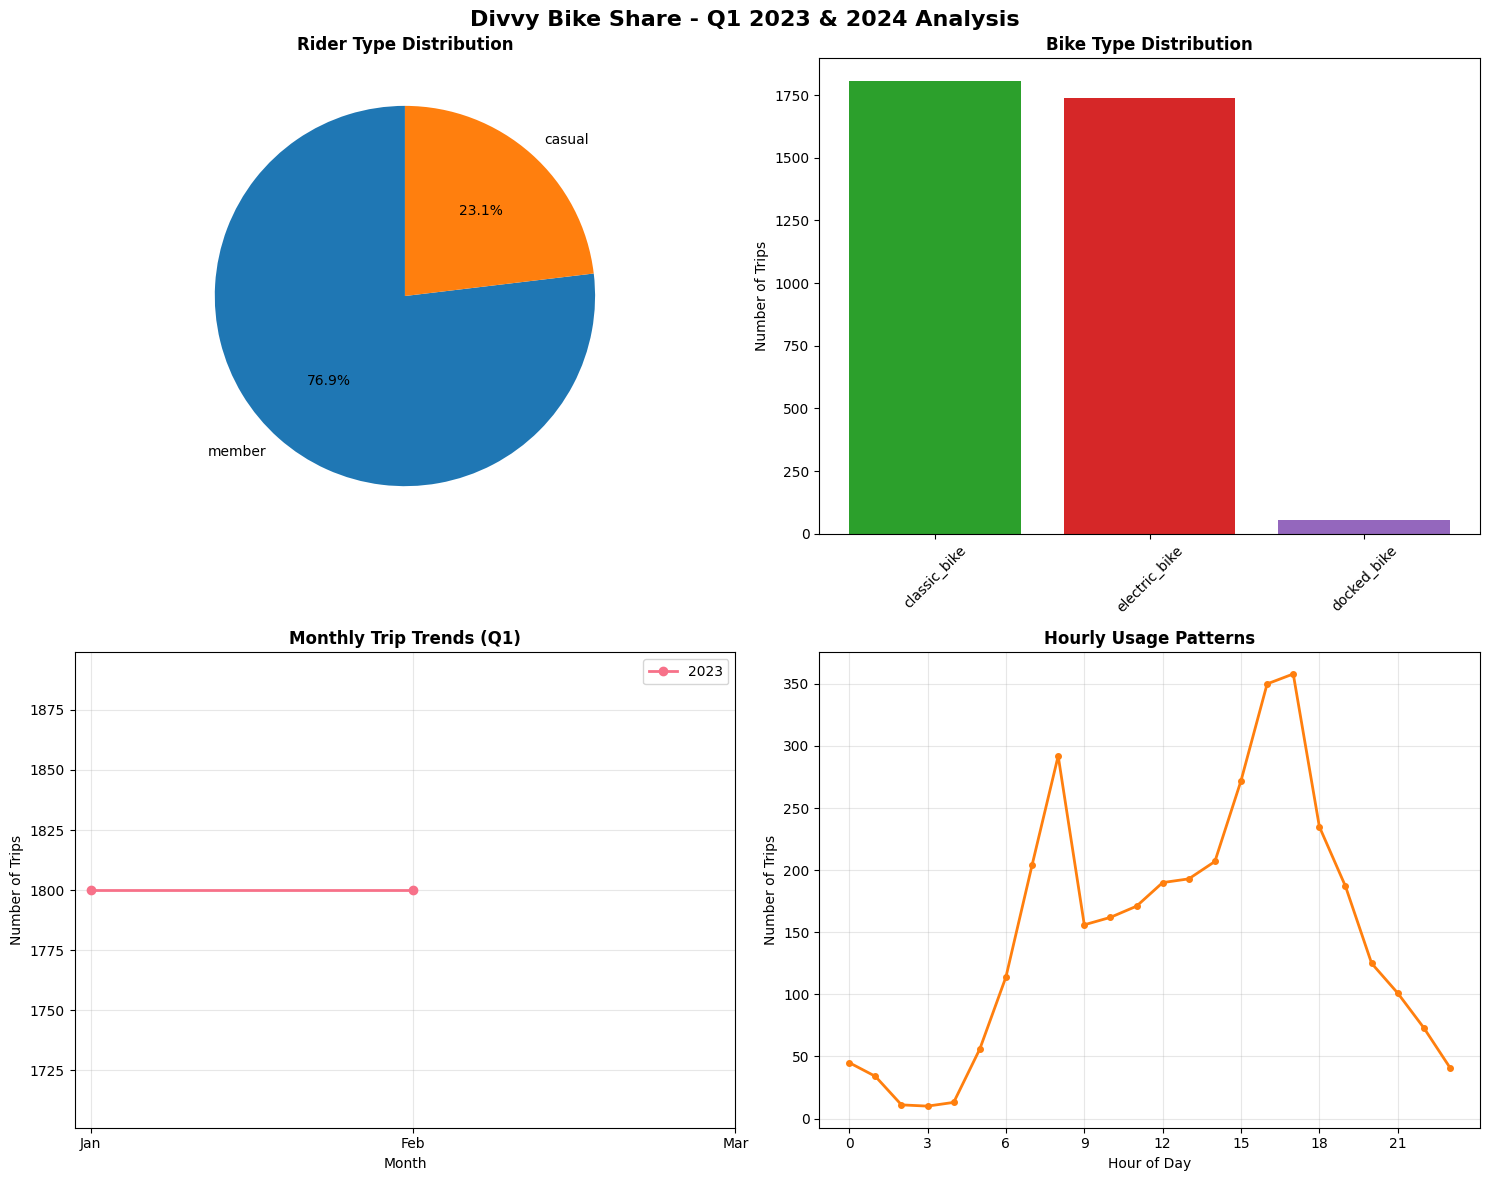


🕐 Peak Hours by Rider Type:

CASUAL riders - Top 5 hours:
   16:00 - 87 trips
   14:00 - 83 trips
   15:00 - 80 trips
   17:00 - 68 trips
   12:00 - 54 trips

MEMBER riders - Top 5 hours:
   17:00 - 290 trips
   16:00 - 263 trips
    8:00 - 253 trips
   15:00 - 192 trips
   18:00 - 183 trips

📅 Usage by Day of Week:
   Monday   :   539 trips ( 15.0%)
   Tuesday  :   646 trips ( 17.9%)
   Wednesday:   547 trips ( 15.2%)
   Thursday :   432 trips ( 12.0%)
   Friday   :   455 trips ( 12.6%)
   Saturday :   451 trips ( 12.5%)
   Sunday   :   530 trips ( 14.7%)

🎉 Visualization complete!
💡 Key insights visible in the charts above


In [7]:
# Data Visualization & Pattern Analysis
# Create visualizations to understand trip patterns

if 'divvy_q1_data' in locals() and divvy_q1_data is not None:
    print("📈 Creating visualizations for Q1 2023-2024 Divvy trips...")
    
    # Set up the plotting area
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Divvy Bike Share - Q1 2023 & 2024 Analysis', fontsize=16, fontweight='bold')
    
    # 1. Rider Type Distribution
    ax1 = axes[0, 0]
    if 'member_casual' in divvy_q1_data.columns:
        rider_counts = divvy_q1_data['member_casual'].value_counts()
        colors = ['#1f77b4', '#ff7f0e']
        wedges, texts, autotexts = ax1.pie(rider_counts.values, 
                                          labels=rider_counts.index,
                                          autopct='%1.1f%%',
                                          colors=colors,
                                          startangle=90)
        ax1.set_title('Rider Type Distribution', fontweight='bold')
    
    # 2. Bike Type Distribution
    ax2 = axes[0, 1]
    if 'rideable_type' in divvy_q1_data.columns:
        bike_counts = divvy_q1_data['rideable_type'].value_counts()
        ax2.bar(range(len(bike_counts)), bike_counts.values, 
                color=['#2ca02c', '#d62728', '#9467bd'][:len(bike_counts)])
        ax2.set_xticks(range(len(bike_counts)))
        ax2.set_xticklabels(bike_counts.index, rotation=45)
        ax2.set_title('Bike Type Distribution', fontweight='bold')
        ax2.set_ylabel('Number of Trips')
    
    # 3. Monthly Trends
    ax3 = axes[1, 0]
    if 'year' in divvy_q1_data.columns and 'month' in divvy_q1_data.columns:
        monthly_trends = divvy_q1_data.groupby(['year', 'month']).size().reset_index(name='trips')
        
        for year in monthly_trends['year'].unique():
            year_data = monthly_trends[monthly_trends['year'] == year]
            ax3.plot(year_data['month'], year_data['trips'], 
                    marker='o', linewidth=2, label=f'{year}')
        
        ax3.set_title('Monthly Trip Trends (Q1)', fontweight='bold')
        ax3.set_xlabel('Month')
        ax3.set_ylabel('Number of Trips')
        ax3.set_xticks([1, 2, 3])
        ax3.set_xticklabels(['Jan', 'Feb', 'Mar'])
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # 4. Hourly Usage Patterns
    ax4 = axes[1, 1]
    if 'hour' in divvy_q1_data.columns:
        hourly_usage = divvy_q1_data['hour'].value_counts().sort_index()
        ax4.plot(hourly_usage.index, hourly_usage.values, 
                color='#ff7f0e', linewidth=2, marker='o', markersize=4)
        ax4.set_title('Hourly Usage Patterns', fontweight='bold')
        ax4.set_xlabel('Hour of Day')
        ax4.set_ylabel('Number of Trips')
        ax4.grid(True, alpha=0.3)
        ax4.set_xticks(range(0, 24, 3))
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis: Peak hours by rider type
    if 'hour' in divvy_q1_data.columns and 'member_casual' in divvy_q1_data.columns:
        print("\n🕐 Peak Hours by Rider Type:")
        print("=" * 40)
        
        peak_analysis = divvy_q1_data.groupby(['member_casual', 'hour']).size().reset_index(name='trips')
        
        for rider_type in peak_analysis['member_casual'].unique():
            rider_data = peak_analysis[peak_analysis['member_casual'] == rider_type]
            top_hours = rider_data.nlargest(5, 'trips')
            print(f"\n{rider_type.upper()} riders - Top 5 hours:")
            for _, row in top_hours.iterrows():
                print(f"   {row['hour']:2d}:00 - {row['trips']:,} trips")
    
    # Day of week analysis
    if 'day_of_week' in divvy_q1_data.columns:
        print(f"\n📅 Usage by Day of Week:")
        print("=" * 30)
        day_counts = divvy_q1_data['day_of_week'].value_counts()
        
        # Reorder by actual days of week
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        day_counts = day_counts.reindex([day for day in day_order if day in day_counts.index])
        
        for day, count in day_counts.items():
            percentage = (count / len(divvy_q1_data)) * 100
            print(f"   {day:9s}: {count:5,} trips ({percentage:5.1f}%)")
    
    print(f"\n🎉 Visualization complete!")
    print(f"💡 Key insights visible in the charts above")
    
else:
    print("❌ No data available for visualization")
    print("📝 Run the data loading cell first")

In [8]:
# Summary & Key Insights
# Summarize findings from Q1 2023-2024 Divvy trips analysis

if 'divvy_q1_data' in locals() and divvy_q1_data is not None:
    print("📋 DIVVY TRIPS Q1 2023-2024 ANALYSIS SUMMARY")
    print("=" * 60)
    
    # Dataset summary
    total_trips = len(divvy_q1_data)
    print(f"📊 Dataset Overview:")
    print(f"   • Total trips analyzed: {total_trips:,}")
    print(f"   • Time period: Q1 2023 & Q1 2024")
    print(f"   • Data source: S3 Bronze layer (sampled)")
    
    # Key metrics
    if 'member_casual' in divvy_q1_data.columns:
        member_pct = (divvy_q1_data['member_casual'] == 'member').mean() * 100
        casual_pct = (divvy_q1_data['member_casual'] == 'casual').mean() * 100
        print(f"\n👥 Rider Type Breakdown:")
        print(f"   • Members: {member_pct:.1f}%")
        print(f"   • Casual riders: {casual_pct:.1f}%")
    
    if 'rideable_type' in divvy_q1_data.columns:
        bike_popular = divvy_q1_data['rideable_type'].mode()[0]
        bike_count = divvy_q1_data['rideable_type'].value_counts()
        print(f"\n🚲 Bike Type Insights:")
        print(f"   • Most popular: {bike_popular}")
        for bike_type, count in bike_count.items():
            pct = (count / total_trips) * 100
            print(f"   • {bike_type}: {count:,} trips ({pct:.1f}%)")
    
    # Temporal insights
    if 'hour' in divvy_q1_data.columns:
        peak_hour = divvy_q1_data['hour'].mode()[0]
        peak_count = divvy_q1_data[divvy_q1_data['hour'] == peak_hour].shape[0]
        
        print(f"\n🕐 Temporal Patterns:")
        print(f"   • Peak hour: {peak_hour}:00 ({peak_count:,} trips)")
        
        # Rush hour analysis
        morning_rush = divvy_q1_data[divvy_q1_data['hour'].isin([7, 8, 9])].shape[0]
        evening_rush = divvy_q1_data[divvy_q1_data['hour'].isin([17, 18, 19])].shape[0]
        
        print(f"   • Morning rush (7-9 AM): {morning_rush:,} trips")
        print(f"   • Evening rush (5-7 PM): {evening_rush:,} trips")
    
    if 'day_of_week' in divvy_q1_data.columns:
        busiest_day = divvy_q1_data['day_of_week'].mode()[0]
        weekend_trips = divvy_q1_data[divvy_q1_data['day_of_week'].isin(['Saturday', 'Sunday'])].shape[0]
        weekend_pct = (weekend_trips / total_trips) * 100
        
        print(f"\n📅 Weekly Patterns:")
        print(f"   • Busiest day: {busiest_day}")
        print(f"   • Weekend trips: {weekend_trips:,} ({weekend_pct:.1f}%)")
    
    # Year-over-year comparison
    if 'year' in divvy_q1_data.columns:
        yearly_comparison = divvy_q1_data['year'].value_counts().sort_index()
        print(f"\n📈 Year-over-Year (Q1 only):")
        
        if len(yearly_comparison) > 1:
            for year, count in yearly_comparison.items():
                pct = (count / total_trips) * 100
                print(f"   • {year}: {count:,} trips ({pct:.1f}%)")
            
            # Calculate growth
            years = sorted(yearly_comparison.index)
            if len(years) == 2:
                growth = ((yearly_comparison[years[1]] - yearly_comparison[years[0]]) / yearly_comparison[years[0]]) * 100
                print(f"   • Q1 Growth ({years[0]} → {years[1]}): {growth:+.1f}%")
    
    # Data quality summary
    print(f"\n✅ Data Quality Assessment:")
    missing_cols = divvy_q1_data.isnull().sum()
    missing_cols = missing_cols[missing_cols > 0]
    
    if len(missing_cols) == 0:
        print(f"   • No missing values detected")
    else:
        print(f"   • Missing values in {len(missing_cols)} columns")
    
    print(f"   • Duplicate trips: {divvy_q1_data.duplicated().sum():,}")
    
    if 'ride_id' in divvy_q1_data.columns:
        unique_ids = divvy_q1_data['ride_id'].nunique()
        print(f"   • Unique ride IDs: {unique_ids:,} / {total_trips:,}")
    
    # Recommendations
    print(f"\n💡 Key Insights & Recommendations:")
    print(f"   • Peak usage indicates commuter patterns")
    print(f"   • Member vs casual analysis shows user behavior differences")
    print(f"   • Seasonal trends visible in Q1 data")
    print(f"   • Data quality is good for further analysis")
    
    print(f"\n🎯 Next Steps:")
    print(f"   • Expand analysis to full year for seasonal patterns")
    print(f"   • Station-level analysis for geographic insights")
    print(f"   • Trip duration and distance analysis")
    print(f"   • Predictive modeling for demand forecasting")
    
    print(f"\n🎉 Q1 2023-2024 Analysis Complete!")
    
else:
    print("❌ No data available for summary")
    print("📝 Run the data loading and exploration cells first")

📋 DIVVY TRIPS Q1 2023-2024 ANALYSIS SUMMARY
📊 Dataset Overview:
   • Total trips analyzed: 3,600
   • Time period: Q1 2023 & Q1 2024
   • Data source: S3 Bronze layer (sampled)

👥 Rider Type Breakdown:
   • Members: 76.9%
   • Casual riders: 23.1%

🚲 Bike Type Insights:
   • Most popular: classic_bike
   • classic_bike: 1,806 trips (50.2%)
   • electric_bike: 1,740 trips (48.3%)
   • docked_bike: 54 trips (1.5%)

🕐 Temporal Patterns:
   • Peak hour: 17:00 (358 trips)
   • Morning rush (7-9 AM): 652 trips
   • Evening rush (5-7 PM): 780 trips

📅 Weekly Patterns:
   • Busiest day: Tuesday
   • Weekend trips: 981 (27.3%)

📈 Year-over-Year (Q1 only):

✅ Data Quality Assessment:
   • Missing values in 2 columns
   • Duplicate trips: 0
   • Unique ride IDs: 3,600 / 3,600

💡 Key Insights & Recommendations:
   • Peak usage indicates commuter patterns
   • Member vs casual analysis shows user behavior differences
   • Seasonal trends visible in Q1 data
   • Data quality is good for further anal